In [1]:
import sys

import xarray as xr
import matplotlib.pyplot as plt
import xgcm
import gcm_filters
import argparse
from dask.diagnostics import ProgressBar
import os
import sys
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Compare December January coarsegraining

In [87]:
old = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/output/prog_full.nc').isel(Time=243).load()

In [90]:
new = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/time_29.nc').load()

In [92]:
restart_example = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/bare/R2/RESTART/MOM.res.nc')[['u', 'v', 'h', 'sfc']].load().squeeze()
topography_restart = (restart_example.sfc - restart_example.h.sum('Layer')).values

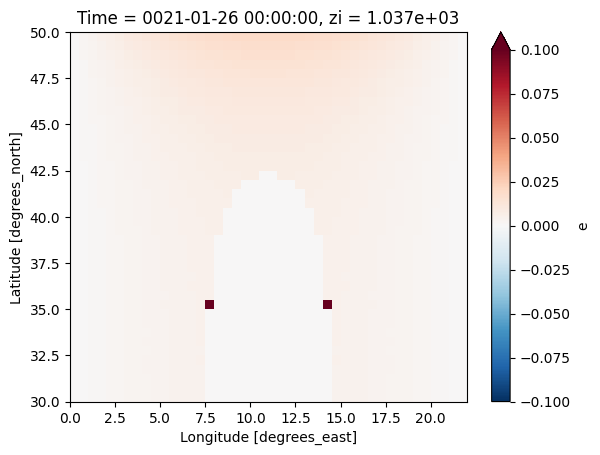

In [99]:
(old.e[2] - new.e[2]).plot(vmin=-1e-1)

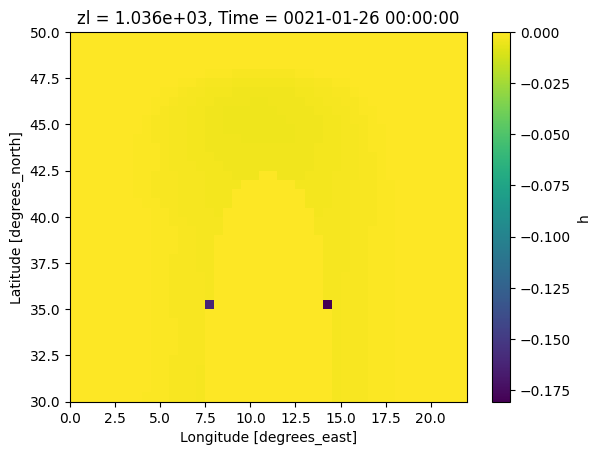

In [117]:
(old.h[1] - new.h[1]).plot()

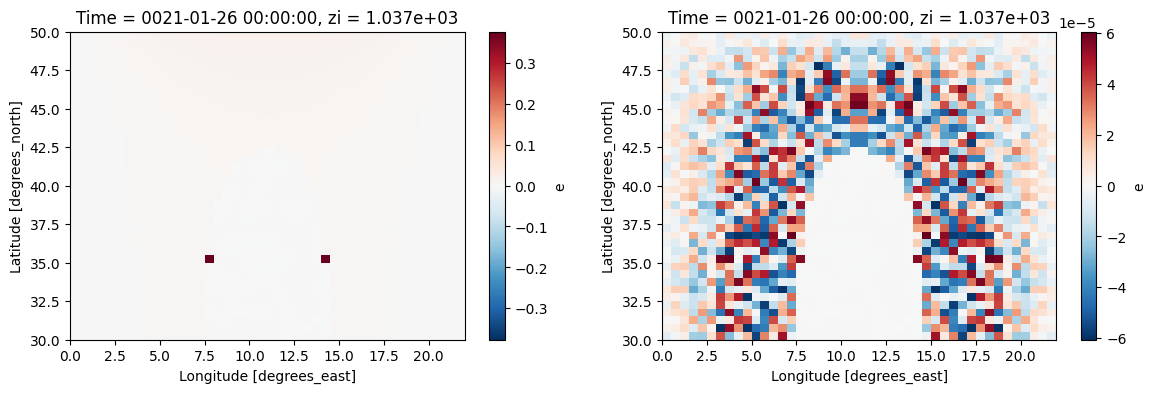

In [100]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(old.e[2] - topography_restart).plot()

plt.subplot(1,2,2)
(new.e[2] - topography_restart).plot()

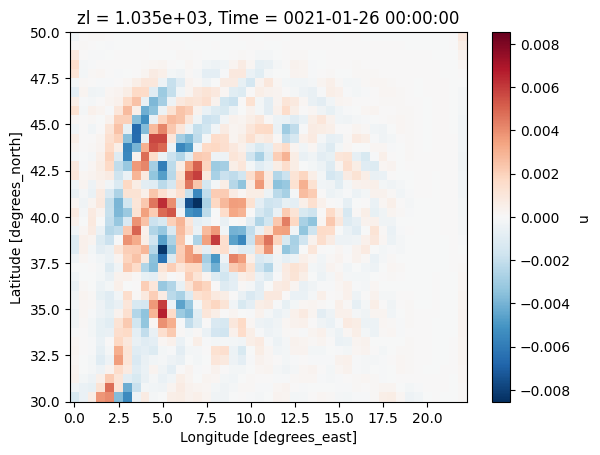

In [101]:
(old.u - new.u)[0].plot()

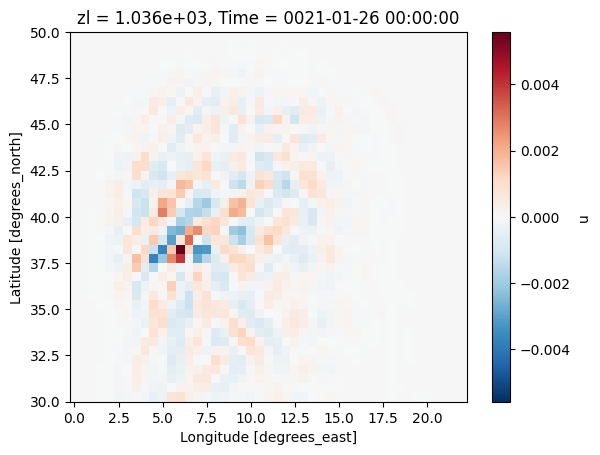

In [102]:
(old.u - new.u)[1].plot()

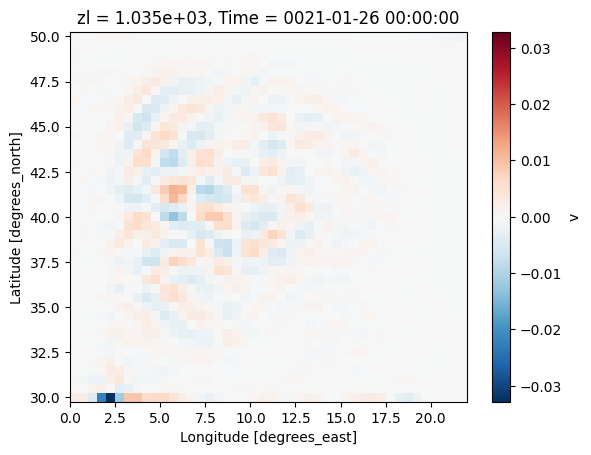

In [103]:
(old.v - new.v)[0].plot()

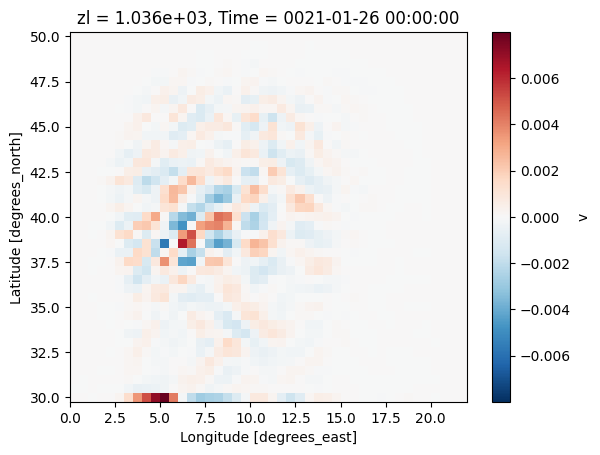

In [104]:
(old.v - new.v)[1].plot()

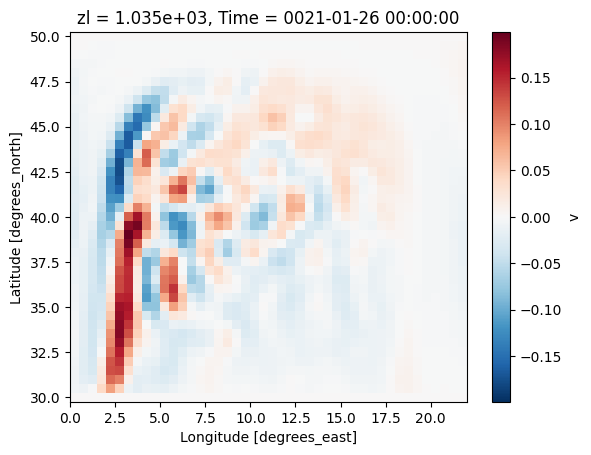

In [107]:
(old.v)[0].plot()

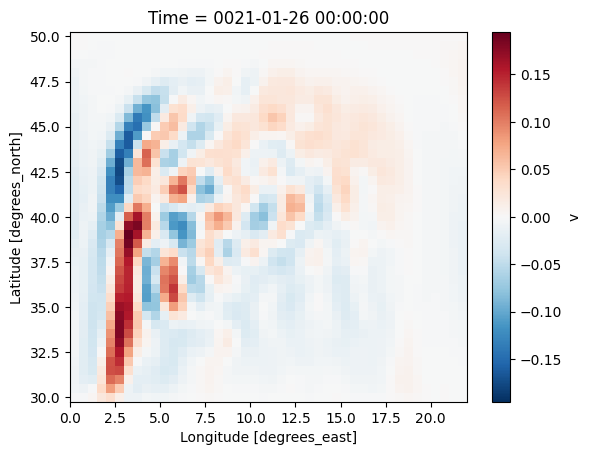

In [108]:
(new.v)[0].plot()

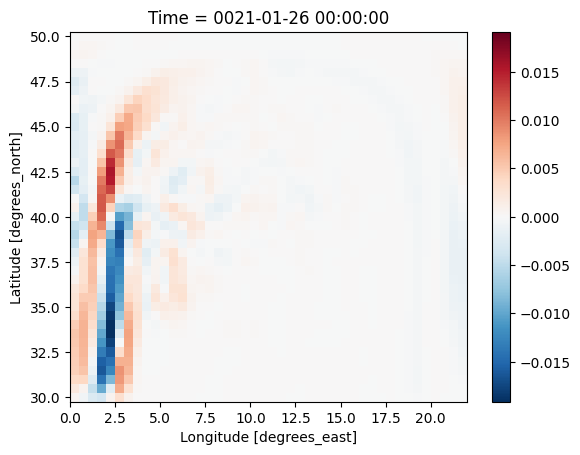

In [109]:
(new.v - new.v_h)[0].plot()

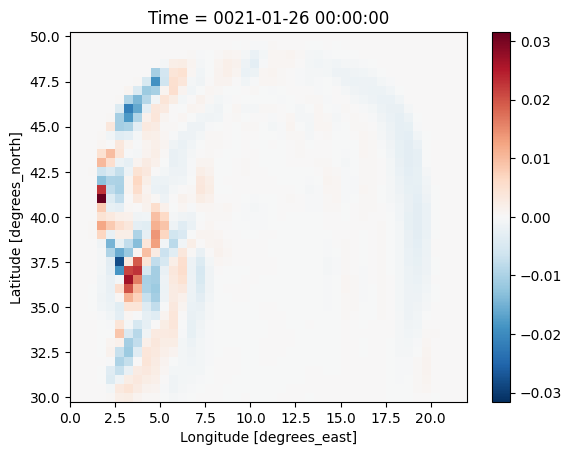

In [110]:
(new.v - new.v_h)[1].plot()

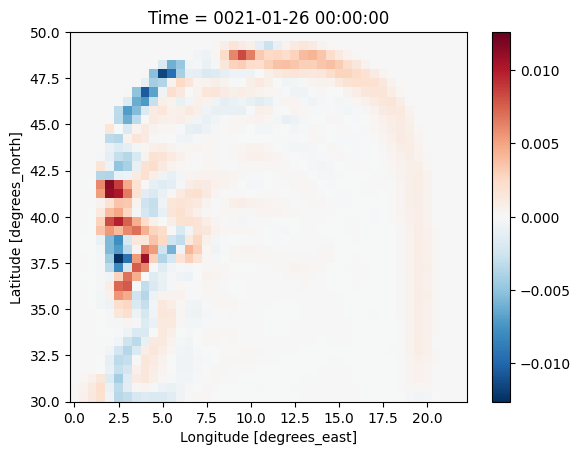

In [111]:
(new.u - new.u_h)[1].plot()

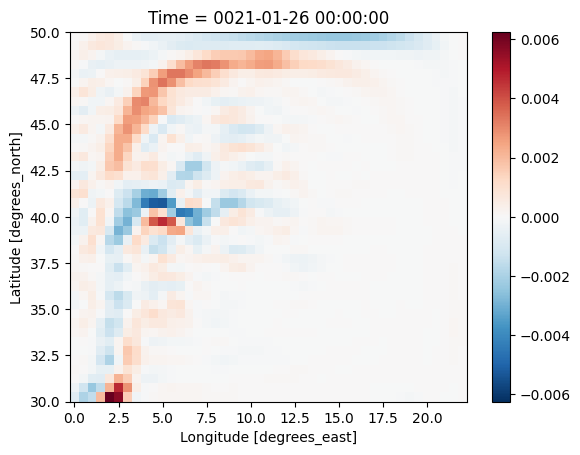

In [112]:
(new.u - new.u_h)[0].plot()

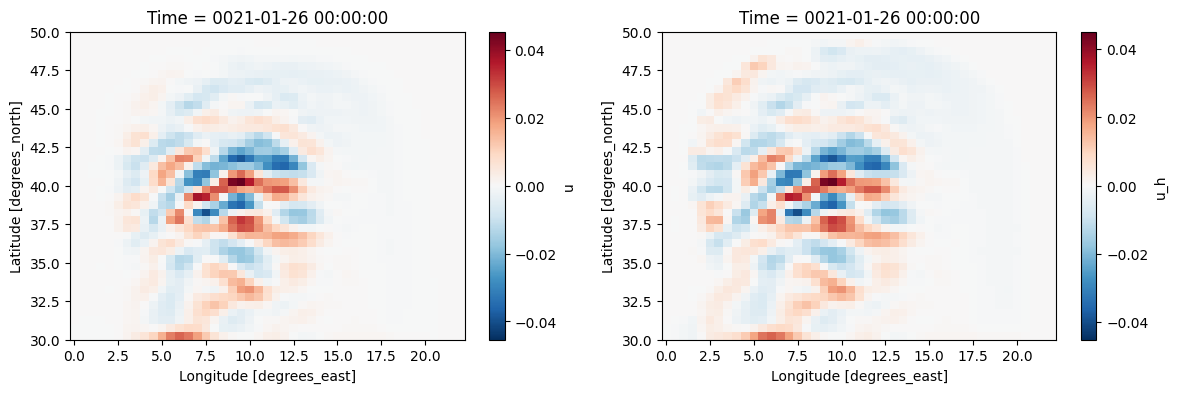

In [120]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
new.u[1].plot()
plt.subplot(1,2,2)
new.u_h[1].plot()

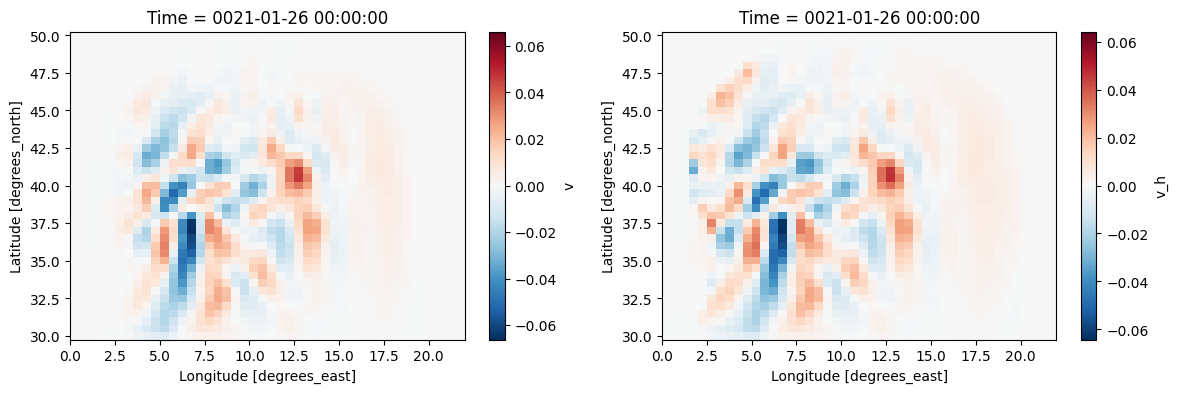

In [121]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
new.v[1].plot()
plt.subplot(1,2,2)
new.v_h[1].plot()

# Prepare restart files TWA and non-TWA

In [4]:
#for time_idx in range(0,1):
time_idx = 0
data = xr.open_dataset(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/time_{time_idx}.nc', decode_times=False).astype('float64').rename({'xh': 'lonh', 'yh': 'lath', 'xq': 'lonq', 'yq': 'latq', 'zl': 'Layer'}).fillna(0.).drop_vars('Time').expand_dims('Time').rename({'e': 'sfc'}).isel(zi=0).drop_vars('zi')

non_TWA = data[['u', 'v', 'h', 'sfc']]
TWA = data[['u_h', 'v_h', 'h', 'sfc']].rename({'u_h': 'u', 'v_h': 'v'})
non_TWA.transpose('Time',...).to_netcdf(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/RESTART_non_TWA/MOM_{time_idx}.res.nc')
TWA.transpose('Time',...).to_netcdf(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/RESTART_TWA/MOM_{time_idx}.res.nc')

# Analyze predictions

In [2]:
data = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/*.nc', decode_times=False, combine='nested', concat_dim='Time').astype('float64').fillna(0.).sortby('Time')
data['Time'] = data['Time'] -  data['Time'].isel(Time=0)

In [3]:
nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R2-non-TWA/prog_*', decode_times=False)
TWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R2-TWA/prog_*', decode_times=False)
eANN_nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-non-TWA/prog_*', decode_times=False)
eANN_TWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-TWA/prog_*', decode_times=False)
eANN_calibrated_nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-non-TWA/prog_*', decode_times=False)

In [10]:
eANN_v1 = xr.open_mfdataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3/iteration-09/R2/ens-member-00/output/prog_*', decode_times=False)
eANN_v2 = xr.open_mfdataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_inflation/iteration-09/R2/ens-member-00/output/prog_*', decode_times=False)
eANN_v3 = xr.open_mfdataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_inflation_v2/iteration-09/R2/ens-member-00/output/prog_*', decode_times=False)

Text(0.5, 1.0, 'Interface, upper layer')

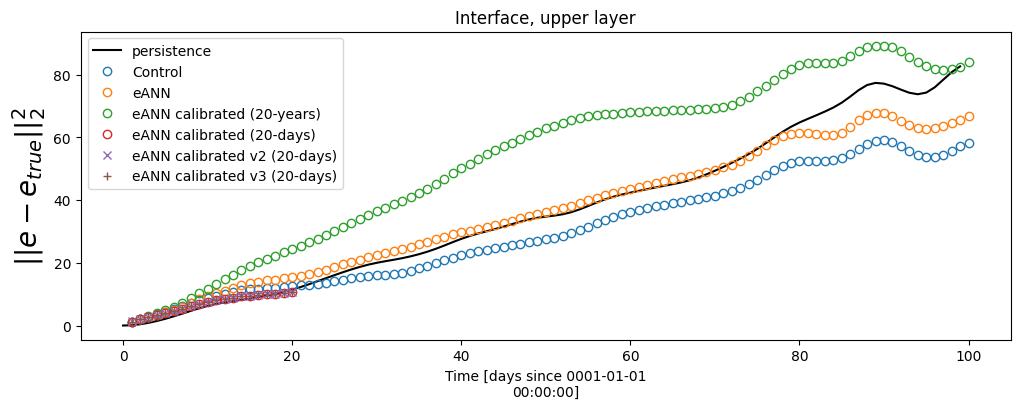

In [16]:
plt.figure(figsize=(12,4))
sel = lambda x: x.e.isel(zi=0)
xy = ['xh', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||e - e_{true}||_2^2$', fontsize=20)
plt.title('Interface, upper layer')

Text(0.5, 1.0, 'Interface, lower layer')

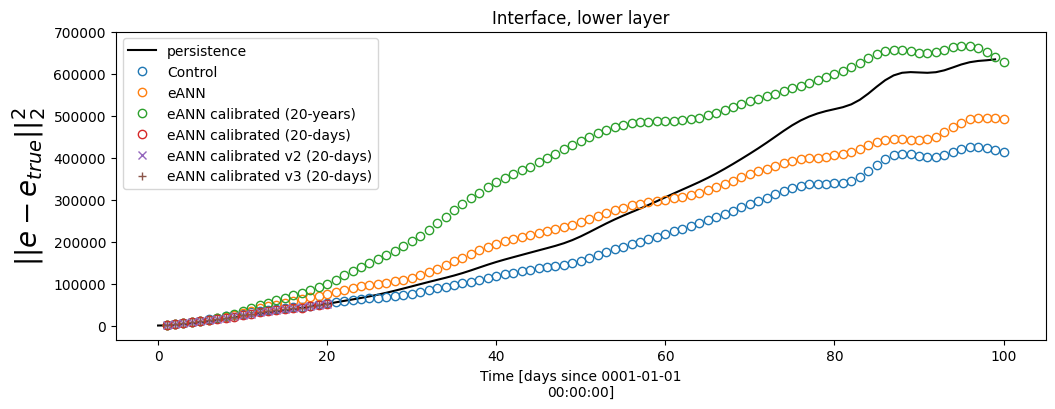

In [17]:
plt.figure(figsize=(12,4))
sel = lambda x: x.e.isel(zi=1)
xy = ['xh', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||e - e_{true}||_2^2$', fontsize=20)
plt.title('Interface, lower layer')

Text(0.5, 1.0, 'Zonal velocity, upper layer')

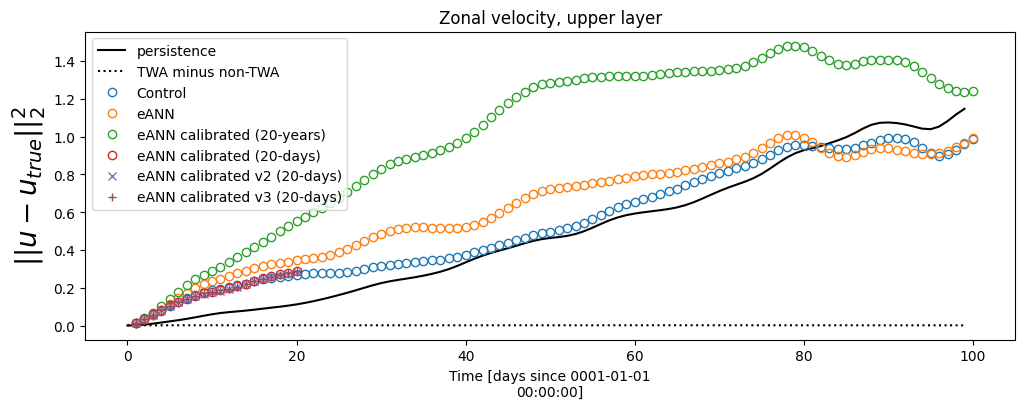

In [18]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=0)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['u'].isel(zl=0) - data['u_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, upper layer')

Text(0.5, 1.0, 'Meridional velocity, upper layer')

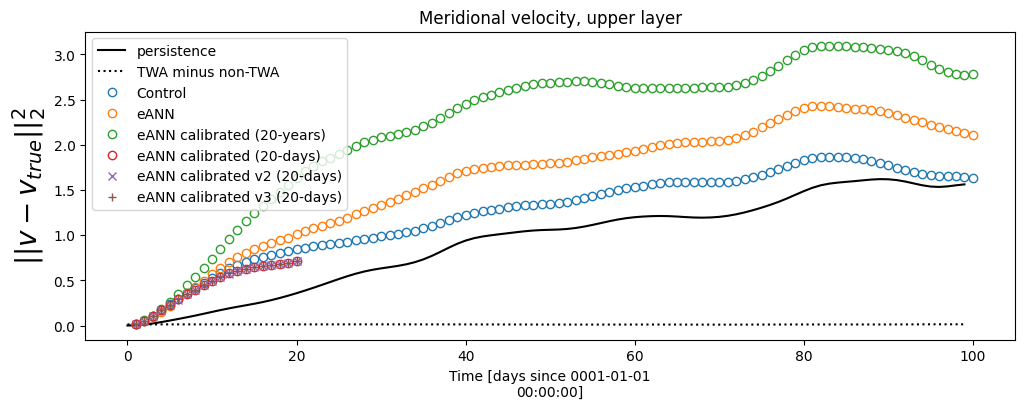

In [19]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=0)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['v'].isel(zl=0) - data['v_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, upper layer')

Text(0.5, 1.0, 'Zonal velocity, lower layer')

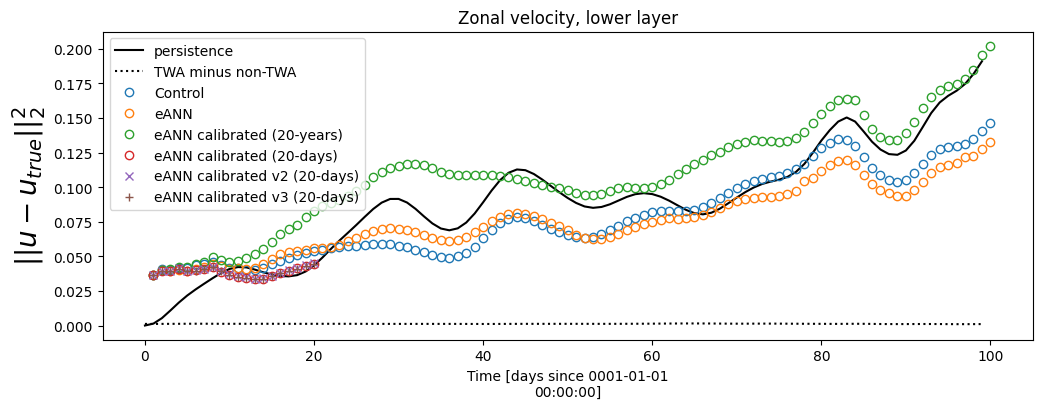

In [20]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=1)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['u'].isel(zl=0) - data['u_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, lower layer')

Text(0.5, 1.0, 'Meridional velocity, lower layer')

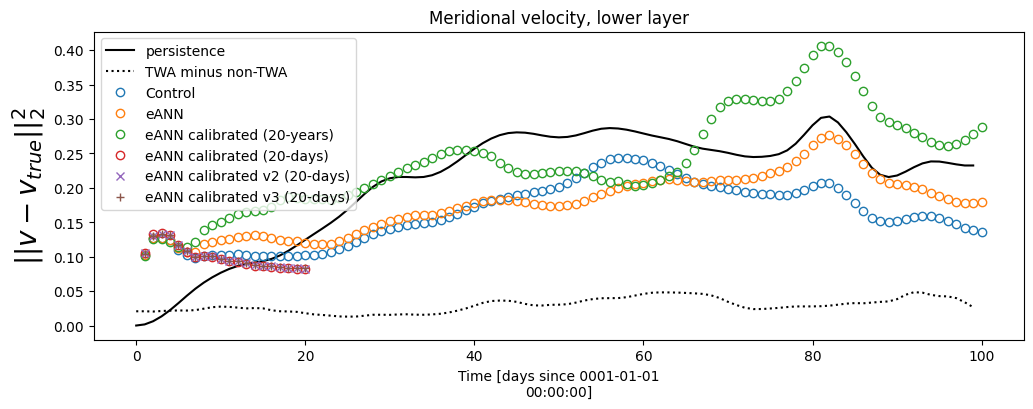

In [21]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=1)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['v'].isel(zl=1) - data['v_h'].isel(zl=1))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, lower layer')

# Smoother metrics for lower. Predicting uh instead of h

In [36]:
# Introduce weighting factor
h_mean = data.h.mean('Time').compute()

In [40]:
lores_static = xr.open_mfdataset(f'/scratch/pp2681/mom6/Feb2022/bare/R2/output/ocean_geometry.nc').rename({'lonh': 'xh', 'lath': 'yh', 'lonq': 'xq', 'latq': 'yq'})

In [41]:
grid_lores = xgcm.Grid(lores_static, coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
        },
        boundary={'X': 'fill', 'Y': 'fill'},
        fill_value = {'Y': 0, 'X': 0})


In [43]:
hu = grid_lores.interp(h_mean, 'X')
hv = grid_lores.interp(h_mean, 'Y')

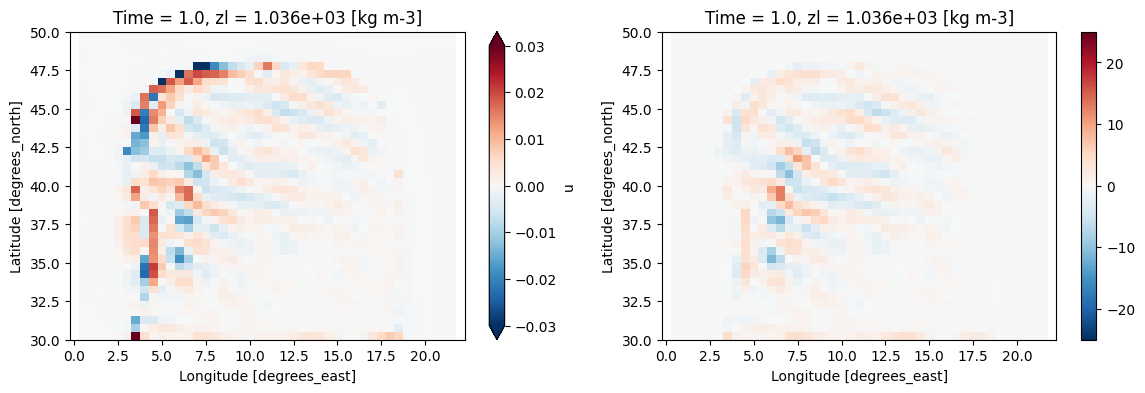

In [54]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[1][1] - nonTWA.u[0][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[1][1] - nonTWA.u[0][1])).plot(vmin=-25)

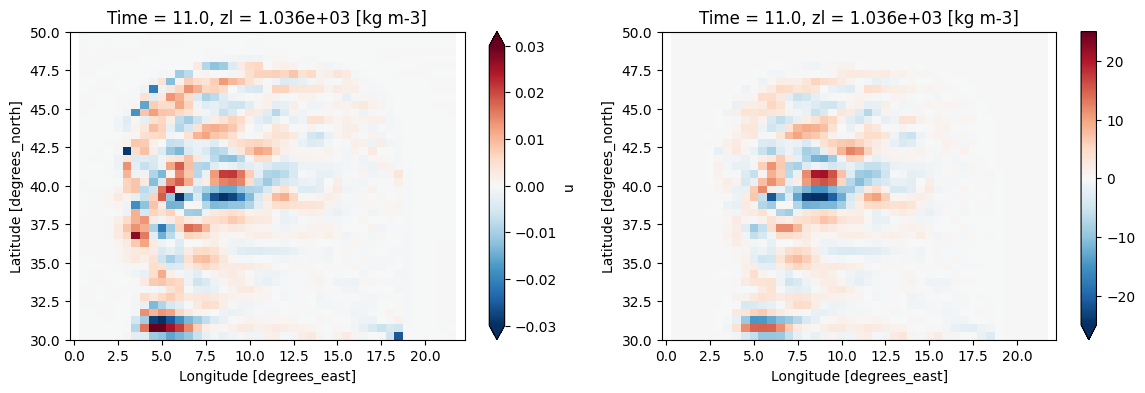

In [53]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[11][1] - nonTWA.u[10][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[11][1] - nonTWA.u[10][1])).plot(vmin=-25)

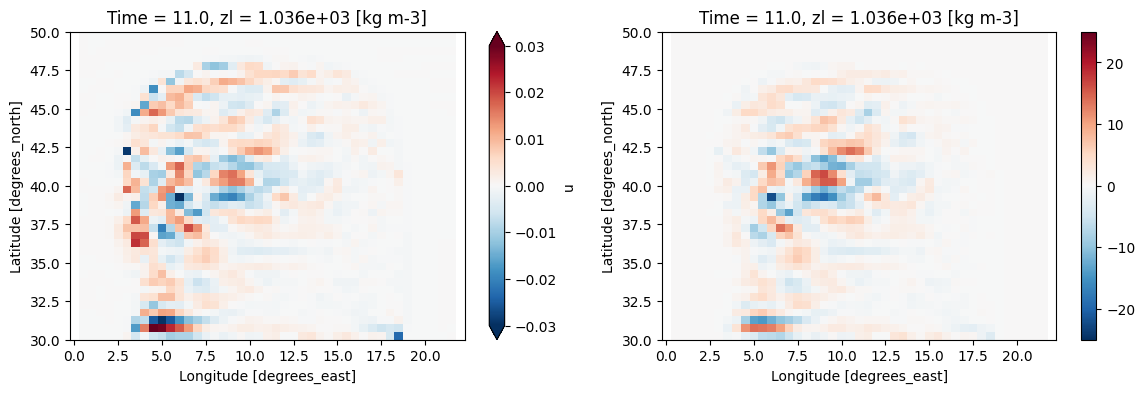

In [62]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[11][1] - eANN_v1.u[10][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[11][1] - eANN_v1.u[10][1])).plot(vmin=-25)

Text(0.5, 1.0, 'Zonal velocity, lower layer')

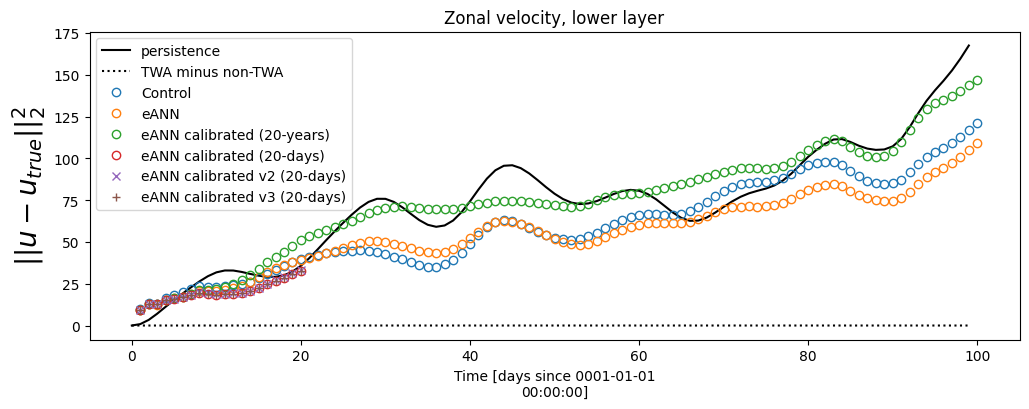

In [48]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=1) * np.sqrt(hu).isel(zl=1)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['u'].isel(zl=0) - data['u_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, lower layer')

Text(0.5, 1.0, 'Meridional velocity, lower layer')

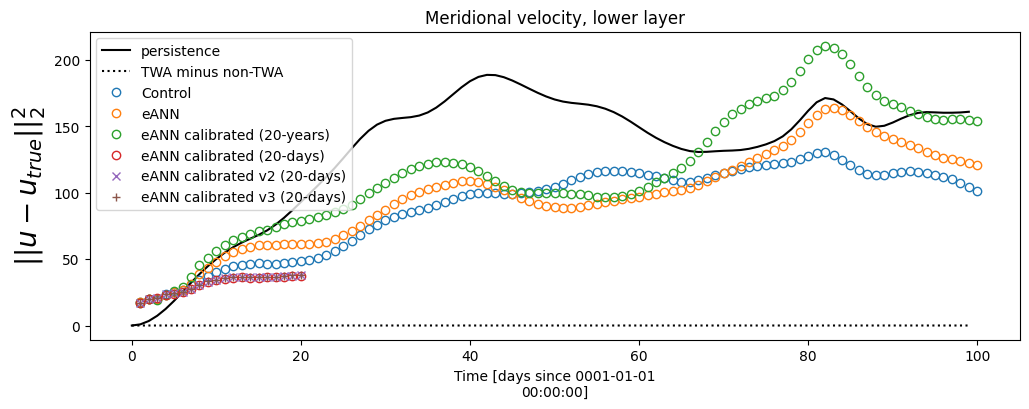

In [56]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=1) * np.sqrt(hv).isel(zl=1)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['v'].isel(zl=0) - data['v_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='+', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, lower layer')

In [61]:
((lores_static.dxT * lores_static.dyT).max() / (lores_static.dxT * lores_static.dyT).min()).compute()

<xarray.DataArray ()> Size: 8B
array(1.33695008)

In [143]:
# The errors introduced by the numerical model are so much larger than the difference between TWA and non-TWA velocities. Thus, information about the trajectory is more important than the details about filtering. So, we proceed with non-TWA framework for simplicitiy, starting with initial time moment, for 20 days.

# Dataset for online training

In [65]:
EKI_dataset = data[['u', 'v']].isel(Time=slice(1,21))
# Simplest measures for the model error -- we use variance of time series
velocity_var = (data['u'].var('Time').mean(['xq', 'yh']) + data['v'].var('Time').mean(['xh', 'yq'])) * 0.5
EKI_dataset['u_var_ave'] = EKI_dataset['u']*0 + velocity_var
EKI_dataset['v_var_ave'] = EKI_dataset['v']*0 + velocity_var
# Introduce weighthing factor. It will be used to define the KE-norm in the EKI algorithm
# We will predict not velocity u, but u*sqrt(h), where sqrt(h) is a time-average. We 
# also get rid of upweighting the lower layer
EKI_dataset['hu'] = grid_lores.interp(data['h'], 'X').mean('Time')
EKI_dataset['hv'] = grid_lores.interp(data['h'], 'Y').mean('Time')
EKI_dataset['u_sqrt_h'] = EKI_dataset['u'] * np.sqrt(EKI_dataset['hu'])
EKI_dataset['v_sqrt_h'] = EKI_dataset['v'] * np.sqrt(EKI_dataset['hv'])

In [66]:
EKI_dataset = EKI_dataset.compute()

In [67]:
EKI_dataset.to_netcdf('../scripts/R32/R2_FGR3_online_training.nc')